# 神经网络基本原理-4

## 1 梯度下降法

## 2 分类算法


## 3 反向传播算法

## 4 反向传播算法的向量化

本小节将反向传播算法向量化，并应用到高维度数据中。



本案例利用二维样本数据，三维隐藏层，二维Softmax输出分类。


In [1]:
# Imports
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np  # Matrix and vector computation package
import sklearn
import sklearn.datasets # To generate the dataset
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
from matplotlib import cm # Colormaps
from matplotlib.colors import colorConverter, ListedColormap
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
import seaborn as sns  # Fancier plots

# Set seaborn plotting style
sns.set_style('darkgrid')
# Set the seed for reproducability
np.random.seed(seed=1)
#

### 4.1 数据集

输入数据$\mathbf{X}\in R^{N\times 2}$

$$
\mathbf{X} = \begin{bmatrix}
x_{11} & x_{12} \\
\vdots & \vdots \\
x_{N1} & x_{N2}
\end{bmatrix}
$$

输出结果： $\mathbf{T}\in R^{N\times 2}$

$$
\mathbf{T} = \begin{bmatrix}
t_{11} & t_{12} \\
\vdots & \vdots \\
t_{N1} & t_{N2}
\end{bmatrix}
$$

图中，蓝色圆形数据为$T=[0,1]$,红色星形数据为$T=[1,0]$。

shape of X: (100, 2)
shape of T: (100, 2)


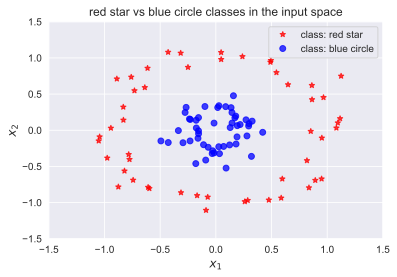

In [32]:
# 生成数据集
X, t = sklearn.datasets.make_circles(
    n_samples=100, shuffle=False, factor=0.3, noise=0.1)
T = np.zeros((100, 2)) # Define target matrix
T[t==1, 1] = 1
T[t==0, 0] = 1
# 利用红蓝两色区分类型
x_red = X[t==0]
x_blue = X[t==1]

print('shape of X: {}'.format(X.shape))
print('shape of T: {}'.format(T.shape))
# 散点图
plt.figure(figsize=(6, 4))
plt.plot(x_red[:,0], x_red[:,1], 'r*', 
         label='class: red star', alpha=0.75)
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', 
         label='class: blue circle', alpha=0.75)
plt.legend(loc=1)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red star vs blue circle classes in the input space')
plt.show()

### 4.2  反向传播的向量化

#### 4.2.1 正向传播


##### 4.2.1.1 隐藏层的激活

隐藏层计算二维输入层映射到三维隐藏层。

![SimpleANN04.png](./14-L7-Neural-network/SimpleANN04.png)

二维输入层数据$\mathbf{X}$，通过权重$\mathbf{W}$，映射到隐藏层$\mathbf{W}_h$,其中，$w_{ij}$链接输入变量i和隐藏层神经元j的权重。

- 权重 
$$
\mathbf{W}_h = 
\begin{bmatrix}
w_{h11} & w_{h12} & w_{h13} \\
w_{h21} & w_{h22} & w_{h23}
 \end{bmatrix}
$$

- 偏置
$$
\mathbf{b}_h = 
\begin{bmatrix}
b_{h1} & b_{h2} & b_{h3} 
 \end{bmatrix}
$$

- 隐藏层激活


$$
\mathbf{H} =  \sigma (\mathbf{X}\cdot \mathbf{W}_h + \mathbf{1}\cdot\mathbf{b}_h ）
$$

其中，$\mathbf{1}= [1, 1, \cdots, 1]^T\in R^{N\times 1} $，见函数hidden_activations(X, Wh, bh)。

- 偏置的矩阵化

$$
\mathbf{\hat{X}} = \begin{bmatrix}
x_{10} & x_{11} & x_{12} \\
\vdots & \vdots & \vdots \\
x_{N0}&  x_{N1} & x_{N2}
\end{bmatrix}
$$
其中$x_{i0}=1$，在矩阵相乘中，权重为偏置系数

$$
\mathbf{\hat{W}}_h = 
\begin{bmatrix}
b_{h1} & b_{h2} & b_{h3}  \\
w_{h11} & w_{h12} & w_{h13} \\
w_{h21} & w_{h22} & w_{h23}
\end{bmatrix}
$$

$$
\mathbf{H} =  \sigma (\mathbf{\hat{X}}\cdot \mathbf{\hat{W}}_h） = \frac{1}{1+e^{-\mathbf{\hat{X}}\cdot \mathbf{\hat{W}}_h}} \in R^{N\times3}
$$


![ANN-projection.png](./14-L7-Neural-network/ANN_layer_projection.png)




##### 4.2.1.2 输出层的激活

输出层计算三维隐藏层结果作为输入映射到二维输出层。

- 输入：隐藏层激活

$$
\mathbf{H} = \begin{bmatrix}
 h_{11} & h_{12} & h_{13} \\
 \vdots & \vdots & \vdots \\
 h_{N1} & h_{N2}  & h_{N3}
\end{bmatrix}
$$

- 权重 

$$
\mathbf{W}_o = \begin{bmatrix}
 w_{o11} & w_{o12}  \\
 w_{o21} & w_{o22}  \\
 w_{o31} & w_{o32}  
\end{bmatrix}
$$

- 偏置

$$
\mathbf{b}_o = \begin{bmatrix} b_{o1} & b_{o2} \end{bmatrix}
$$

- 输出函数


$$
\mathbf{Y} = \zeta(\mathbf{H}\cdot\mathbf{W}_o+\mathbf{1}\cdot\mathbf{b}_o)=\frac{e^{\mathbf{Z}_o}}{\sum_{i=0}^{N}e^{z_{oi}}}=\begin{bmatrix}
 y_{11} & y_{12}  \\
 \vdots & \vdots  \\
 y_{N1} & y_{N2}  
\end{bmatrix}
$$

- 偏置作为权重

$$
\mathbf{\hat{H}} = \begin{bmatrix}
h_{10} & h_{11} & h_{12} & h_{13} \\
 \vdots & \vdots & \vdots & \vdots \\
h_{N0} & h_{N1} & h_{N2}  & h_{N3}
\end{bmatrix}
$$
其中，$h_{i0}=1$，作为于偏置相乘的元素。 

$$
\mathbf{\hat{W}}_o = \begin{bmatrix}
b_{o1} & b_{o2}  \\
w_{o11} & w_{o12}  \\
w_{o21} & w_{o22}  \\
w_{o31} & w_{o32}  
\end{bmatrix}
$$

$$
\mathbf{Y} =  \zeta(\mathbf{Z}_o) = \zeta(\mathbf{\hat{H}}\cdot\mathbf{\hat{W}}_o) 
$$

In [33]:
def logistic(z):
    """逻辑函数"""
    return 1. / (1. + np.exp(-z))


def softmax(z):
    """Softmax 函数"""
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)


def hidden_activations(X, Wh, bh):
    """ 计算隐藏层激活H"""
    # 此处 Nx3矩阵+ 1x3 向量 
    # 注意此处Python处理矩阵加法的方式。
    return logistic((X @ Wh) + bh)


def output_activations(H, Wo, bo):
    """计算输出量y"""
    return softmax((H @ Wo) + bo)



def nn(X, Wh, bh, Wo, bo):
    """神经网络函数"""
    return output_activations(hidden_activations(X, Wh, bh), Wo, bo)


def nn_predict(X, Wh, bh, Wo, bo):
    """神经网络预测，只返回1 或 0"""
    return np.around(nn(X, Wh, bh, Wo, bo))

In [34]:
def logistic(z):
    """Logistic function."""
    return 1. / (1. + np.exp(-z))


def softmax(z):
    """Softmax function"""
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)


def hidden_activations(X, Wh, bh):
    """Compute the hidden activations h"""
    return logistic((X @ Wh) + bh)


def output_activations(H, Wo, bo):
    """Compute the output y"""
    return softmax((H @ Wo) + bo)


def nn(X, Wh, bh, Wo, bo):
    """Neural network as function."""
    return output_activations(hidden_activations(X, Wh, bh), Wo, bo)


def nn_predict(X, Wh, bh, Wo, bo):
    """Neural network prediction function that only returns
    1 or 0 depending on the predicted class"""
    return np.around(nn(X, Wh, bh, Wo, bo))

#### 4.2.1 反向传播

##### 4.2.1.1  输出层的反向传播
- 输出层的误差

本案例的输出层为Softmax层，采用交叉熵损失函数。对于N样本、K类的损失函数：

$$
L(\mathbf{T},\mathbf{Y})=\sum_{i=1}^{N}L(\mathbf{t}_i,\mathbf{y}_i)=-\sum_{i=1}^{N}\sum_{k=1}^{K}t_{ik}\log y_{ik}
$$

损失函数在Softmax输出层的误差梯度为：

$$
\delta_o= \frac{\partial L}{\partial \mathbf{Z}_o}=\mathbf{Y}-\mathbf{T}\in R^{N\times2}
$$

$\delta_o$对应代码中的变量Eo,函数error_output(Y-T)。
- 输出层的权重

在输出层，相对权重的梯度$\delta_{\mathbf{w}_{oj}}=\partial L / \partial \mathbf{w}_{oj}$，
$$
\frac{\partial L }{\partial \mathbf{w}_{oj}}=\frac{\partial L}{\partial \mathbf{Y}}\frac{\partial \mathbf{Y}}{\partial \mathbf{Z}_o}\frac{\partial \mathbf{Z}_o}{\partial \mathbf{w}_{oj}}=\frac{\partial L}{\partial \mathbf{Z}_o}\frac{\partial \mathbf{Z}_o}{\partial \mathbf{w}_{oj}}=\sum_{i=1}^N h_{ij} (\mathbf{y}_i-\mathbf{t}_i)=\sum_{i=1}^N h_{ij}\delta_{oi}
$$

改写为矩阵形式,即雅可比矩阵
$$
J_{\mathbf{W}_o} = \frac{\partial L}{\partial \mathbf{W}_o}
=\begin{bmatrix}
\frac{\partial L}{\partial w_{o11}} & \frac{\partial L}{\partial w_{o12}} \\
\frac{\partial L}{\partial w_{o21}} & \frac{\partial L}{\partial w_{o22}} \\
\frac{\partial L}{\partial w_{o31}} & \frac{\partial L}{\partial w_{o32}}
\end{bmatrix}
=\mathbf{H}^T\cdot \delta_o
$$

雅可比矩阵$J_{\mathbf{W}_o}$对应代码中的Jwo，函数gradient_weight_out(H, Eo)。

- 输出层的偏置

同理，可处理输出层的偏置。

$$
J_{\mathbf{b}_o}= \frac{\partial L }{\partial \mathbf{b}_{o}}=\frac{\partial L}{\partial \mathbf{Y}}\frac{\partial \mathbf{Y}}{\partial \mathbf{Z}_o}\frac{\partial \mathbf{Z}_o}{\partial \mathbf{b}_{o}}=\sum_{i=1}^N 1\cdot (\mathbf{y}_i-\mathbf{t}_i)=\sum_{i=1}^N \delta_{oi}
$$

$J_{\mathbf{b}_o}$在代码中对于Jbo,函数为gradient_bias_out(Eo)。



In [36]:
def loss(Y, T):
    """Loss function"""
    return - (T * np.log(Y)).sum()


def error_output(Y, T):
    """Error function at the output"""
    return Y - T


def gradient_weight_out(H, Eo):
    """Gradients for the weight parameters at the output layer"""
    return  H.T @ Eo


def gradient_bias_out(Eo):
    """Gradients for the bias parameters at the output layer"""
    return  np.sum(Eo, axis=0, keepdims=True)

##### 4.2.1.2  隐藏层的反向传播

- 隐藏层的误差

损失函数在隐藏层的误差梯度为

$$
\delta_h= \frac{\partial L}{\partial \mathbf{Z}_h} =\frac{\partial L}{\partial \mathbf{Z}_o}\frac{{\partial \mathbf{Z}_o}}{\partial \mathbf{H}}\frac{\partial \mathbf{H}}{\partial \mathbf{Z}_h} \in R^{N\times 3} 
$$
其中，$\mathbf{Z}_h = \mathbf{X}\cdot \mathbf{W}_h+\mathbf{1}\cdot\mathbf{b}_h  \in R^{N\times 3}$是隐藏层逻辑函数的输入.

首先计算误差梯度$\delta_{h_{ij}}$，相对输入i在神经元j出的梯度

$$
\delta_{h_{ij}}= \frac{\partial L}{\partial z_{h_{ij}}}= \frac{\partial L}{\partial \mathbf{z}_{oi}}\frac{\partial \mathbf{z}_{oi}}{h_{ij}}\frac{h_{ij}}{\partial z_{h_{ij}}} = h_{ij}(1-h_{ij})\sum_{k=1,2}w_{ojk}(y_{ik}-t{ik})=h_{ij}(1-h_{ij})[\delta_{oi}\cdot \mathbf{w}_{oj}^T]
$$
其中，$\mathbf{w}_{oj}\in R^{1\times2}$是$\mathbf{W}_o$的第j行, $\delta_{oi}\in R^{1\times2}$
, 误差矩阵$\delta_h\in R^{N\times3}$可表示为，
$$
\delta_h =\frac{\partial L}{\partial \mathbf{Z}_h} = \mathbf{H}\odot(1-\mathbf{H})\odot[\delta_o\cdot \mathbf{W}_o^T]
$$

其中，$\odot$代表元素元素相乘。

$\delta_h$对应程序中Eh,函数error_hidden(H, Wo, Eo) 。

- 隐藏层的权重

在隐藏层，损失函数对于权重的梯度为（对于N个样本）

$$
\frac{\partial L}{\partial \mathbf{w}_{hj}}=\frac{\partial L}{\partial \mathbf{H}}\frac{\partial \mathbf{H}}{\partial \mathbf{Z}_h}\frac{\partial \mathbf{Z}_h}{\partial \mathbf{w}_{hj}}=\frac{\partial L}{\partial \mathbf{Z}_h}\frac{\partial \mathbf{Z}_h}{\partial \mathbf{w}_{hj}}=\sum_{i=1}^N x_{ij}\delta_{ij}
$$

$ \mathbf{w}_{hj}\in R^{1\times3}$ 是$\mathbf{W}_h$的第j行,所以，以上公式改写为矩阵形式（雅可比矩阵）：

$$
J_{\mathbf{W}_h}=\frac{\partial L }{\partial \mathbf{W}_h } = \mathbf{X}^T\cdot\delta_h=
\begin{bmatrix}
\frac{\partial L }{\partial w_{h11}}  & \frac{\partial L }{\partial w_{h12}} & \frac{\partial L }{\partial w_{h13}} \\
\frac{\partial L }{\partial w_{h21}}  & \frac{\partial L }{\partial w_{h22}} & \frac{\partial L }{\partial w_{h23}} 
\end{bmatrix}
$$

$J_{\mathbf{W}_h}$在代码中对于变量JWh,函数gradient_weight_hidden(X, Eh)。

- 隐藏层的偏置

同理处理偏置：

$$
\frac{\partial L}{\partial \mathbf{b}_{h}}=\frac{\partial L}{\partial \mathbf{H}}\frac{\partial \mathbf{H}}{\partial \mathbf{Z}_h}\frac{\partial \mathbf{Z}_h}{\partial \mathbf{b}_{h}}=\sum_{j=1}^N \delta_{hj}
$$

损失函数相对偏置的梯度，即雅可比矩阵为


$$
J_{\mathbf{b}_h}=\frac{\partial L }{\partial \mathbf{b}_h } =
\begin{bmatrix}
\frac{\partial L }{\partial b_{h1}}  & \frac{\partial L }{\partial b_{h2}} & \frac{\partial L }{\partial b_{h3}} 
\end{bmatrix}
$$

$J_{\mathbf{b}_h}$ 对于程序中的变量Jbh,函数 gradient_bias_hidden(Eh)。

In [38]:
def error_hidden(H, Wo, Eo):
    """Error at the hidden layer.
    H * (1-H) * (E . Wo^T)"""
    return np.multiply(np.multiply(H,(1 - H)), (Eo @ Wo.T))


def gradient_weight_hidden(X, Eh):
    """Gradient for the weight parameters at the hidden layer"""
    return X.T @ Eh


def gradient_bias_hidden(Eh):
    """Gradient for the bias parameters at the output layer"""
    return  np.sum(Eh, axis=0, keepdims=True)

In [ ]:
#### 4.2.2  数值误差检测

利用数值梯度，检测梯度值是否与真实梯度相符。

In [ ]:
# Run Gradient checking

# Initialize weights and biases
init_var = 1
# Initialize hidden layer parameters
bh = np.random.randn(1, 3) * init_var
Wh = np.random.randn(2, 3) * init_var
# Initialize output layer parameters
bo = np.random.randn(1, 2) * init_var
Wo = np.random.randn(3, 2) * init_var

# Compute the gradients by backpropagation
# Compute the activations of the layers
H = hidden_activations(X, Wh, bh)
Y = output_activations(H, Wo, bo)
# Compute the gradients of the output layer
Eo = error_output(Y, T)
JWo = gradient_weight_out(H, Eo)
Jbo = gradient_bias_out(Eo)
# Compute the gradients of the hidden layer
Eh = error_hidden(H, Wo, Eo)
JWh = gradient_weight_hidden(X, Eh)
Jbh = gradient_bias_hidden(Eh)

# Combine all parameter matrices in a list
params = [Wh, bh, Wo, bo]
# Combine all parameter gradients in a list
grad_params = [JWh, Jbh, JWo, Jbo]

# Set the small change to compute the numerical gradient
eps = 0.0001

# Check each parameter matrix
for p_idx in range(len(params)):
    # Check each parameter in each parameter matrix
    for row in range(params[p_idx].shape[0]):
        for col in range(params[p_idx].shape[1]):
            # Copy the parameter matrix and change the current 
            #  parameter slightly
            p_matrix_min = params[p_idx].copy()
            p_matrix_min[row,col] -= eps
            p_matrix_plus = params[p_idx].copy()
            p_matrix_plus[row,col] += eps
            # Copy the parameter list, and change the updated 
            #  parameter matrix
            params_min = params[:]
            params_min[p_idx] = p_matrix_min
            params_plus = params[:]
            params_plus[p_idx] =  p_matrix_plus
            # Compute the numerical gradient
            grad_num = (
                loss(nn(X, *params_plus), T)-loss(nn(X, *params_min), T)
            ) / (2 * eps)
            # Raise error if the numerical grade is not close to the 
            #  backprop gradient
            if not np.isclose(grad_num, grad_params[p_idx][row,col]):
                raise ValueError((
                    f'Numerical gradient of {grad_num:.6f} '
                    'is not close to the backpropagation '
                    f'gradient of {grad_params[p_idx][row,col]:.6f}!'))
print('No gradient errors found')
#


### 4.3  动量梯度下降法 

梯度下降法适用于优化凸函数的参数，但是包含非线性激活函数多层神经网络中，损失函数极有可能不是凸函数，所以梯度下降法并非是寻找损失函数全局极小值的最佳方法。

[梯度下降法动态演示](https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c)

[梯度下降法可视化程序](https://github.com/lilipads/gradient_descent_viz)



In [39]:
def backprop_gradients(X, T, Wh, bh, Wo, bo):
    """Update the network parameters over 1 iteration."""
    # Compute the output of the network
    # Compute the activations of the layers
    H = hidden_activations(X, Wh, bh)
    Y = output_activations(H, Wo, bo)
    # Compute the gradients of the output layer
    Eo = error_output(Y, T)
    JWo = gradient_weight_out(H, Eo)
    Jbo = gradient_bias_out(Eo)
    # Compute the gradients of the hidden layer
    Eh = error_hidden(H, Wo, Eo)
    JWh = gradient_weight_hidden(X, Eh)
    Jbh = gradient_bias_hidden(Eh)
    return [JWh, Jbh, JWo, Jbo]


def update_momentum(X, T, ls_of_params, Ms, momentum_term, 
                    learning_rate):
    """Update the momentum term."""
    # ls_of_params = [Wh, bh, Wo, bo]
    # Js = [JWh, Jbh, JWo, Jbo]
    Js = backprop_gradients(X, T, *ls_of_params)
    return [momentum_term * M - learning_rate * J 
            for M,J in zip(Ms, Js)]

def update_params(ls_of_params, Ms):
    """Update the parameters."""
    # ls_of_params = [Wh, bh, Wo, bo]
    # Ms = [MWh, Mbh, MWo, Mbo]
    return [P + M for P,M in zip(ls_of_params, Ms)]

In [40]:
# Run backpropagation
# Initialize weights and biases
init_var = 0.1
# Initialize hidden layer parameters
bh = np.random.randn(1, 3) * init_var
Wh = np.random.randn(2, 3) * init_var
# Initialize output layer parameters
bo = np.random.randn(1, 2) * init_var
Wo = np.random.randn(3, 2) * init_var
# Parameters are already initilized randomly with the gradient checking
# Set the learning rate
learning_rate = 0.02
momentum_term = 0.9

# Moments Ms = [MWh, Mbh, MWo, Mbo]
Ms = [np.zeros_like(M) for M in [Wh, bh, Wo, bo]]

# Start the gradient descent updates and plot the iterations
nb_of_iterations = 300  # number of gradient descent updates
# learning rate update rule
lr_update = learning_rate / nb_of_iterations
# list of loss over the iterations
ls_loss = [loss(nn(X, Wh, bh, Wo, bo), T)]
for i in range(nb_of_iterations):
    # Update the moments and the parameters
    Ms = update_momentum(
        X, T, [Wh, bh, Wo, bo], Ms, momentum_term, learning_rate)
    Wh, bh, Wo, bo = update_params([Wh, bh, Wo, bo], Ms)
    ls_loss.append(loss(nn(X, Wh, bh, Wo, bo), T))

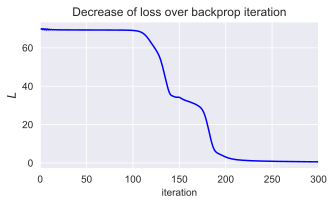

In [44]:
# Plot the loss over the iterations
fig = plt.figure(figsize=(5, 3))
plt.plot(ls_loss, 'b-')
plt.xlabel('iteration')
plt.ylabel('$L$', fontsize=12)
plt.title('Decrease of loss over backprop iteration')
plt.xlim(0, 300)
fig.subplots_adjust(bottom=0.2)
plt.show()
#

In [29]:
def loss(Y, T):
    """损失函数"""
    return - (T * np.log(Y)).sum()


def error_output(Y, T):
    """输出层的误差函数"""
    return Y - T


def gradient_weight_out(H, Eo):
    """在输出层，相对参数的梯度"""
    return  H.T @ Eo


def gradient_bias_out(Eo):
    """在输出层，相对偏置的梯度"""
    return  np.sum(Eo, axis=0, keepdims=True)

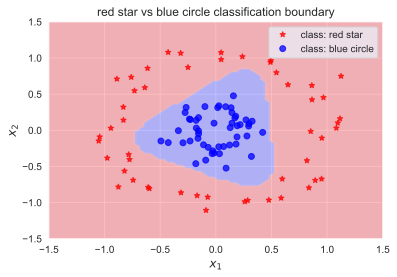

In [42]:
# Plot the resulting decision boundary
# Generate a grid over the input space to plot the color of the
#  classification at that grid point
nb_of_xs = 100
xs1 = np.linspace(-2, 2, num=nb_of_xs)
xs2 = np.linspace(-2, 2, num=nb_of_xs)
xx, yy = np.meshgrid(xs1, xs2) # create the grid
# Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        pred = nn_predict(
            np.asarray([xx[i,j], yy[i,j]]), Wh, bh, Wo, bo)
        classification_plane[i,j] = pred[0, 0]
# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('b', alpha=0.25),
        colorConverter.to_rgba('r', alpha=0.25)])
plt.figure(figsize=(6, 4))
# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, classification_plane, cmap=cmap)
# Plot both classes on the x1, x2 plane
plt.plot(x_red[:,0], x_red[:,1], 
         'r*', label='class: red star', alpha=0.75)
plt.plot(x_blue[:,0], x_blue[:,1], 
         'bo', label='class: blue circle', alpha=0.75)
plt.legend(loc=1)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red star vs blue circle classification boundary')
plt.show()

In [30]:
def error_hidden(H, Wo, Eo):
    """隐藏层的误差函数 H * (1-H) * (E . Wo^T)"""
    return np.multiply(np.multiply(H,(1 - H)), (Eo @ Wo.T))


def gradient_weight_hidden(X, Eh):
    """在隐藏层，相对权重的梯度"""
    return X.T @ Eh


def gradient_bias_hidden(Eh):
    """在输出层，相对于偏置的梯度"""
    return  np.sum(Eh, axis=0, keepdims=True)

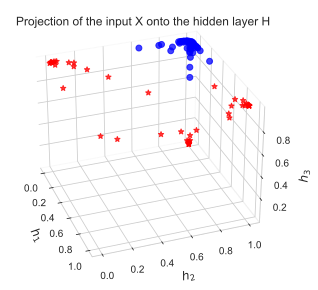

In [43]:
# Plot the projection of the input onto the hidden layer

# Define the projections of the blue and red classes
H_blue = hidden_activations(x_blue, Wh, bh)
H_red = hidden_activations(x_red, Wh, bh)
# Plot the error surface
fig = plt.figure(figsize=(6, 5))
with sns.axes_style("whitegrid"):
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.plot(
        np.ravel(H_blue[:,0]), np.ravel(H_blue[:,1]), np.ravel(H_blue[:,2]),
        'bo', label='class: blue circle', alpha=0.75)
    ax.plot(
        np.ravel(H_red[:,0]), np.ravel(H_red[:,1]), np.ravel(H_red[:,2]), 
        'r*', label='class: red star', alpha=0.75)
    ax.set_xlabel('$h_1$', fontsize=12)
    ax.set_ylabel('$h_2$', fontsize=12)
    ax.set_zlabel('$h_3$', fontsize=12)
    ax.view_init(elev=30, azim=-20)
    ax.set_title('Projection of the input X onto the hidden layer H', y=0.99)
plt.show()

In [31]:
# 梯度检测

# Initialize weights and biases
init_var = 1
# Initialize hidden layer parameters
bh = np.random.randn(1, 3) * init_var
Wh = np.random.randn(2, 3) * init_var
# Initialize output layer parameters
bo = np.random.randn(1, 2) * init_var
Wo = np.random.randn(3, 2) * init_var

# Compute the gradients by backpropagation
# Compute the activations of the layers


H = hidden_activations(X, Wh, bh)



Y = output_activations(H, Wo, bo)
# Compute the gradients of the output layer
Eo = error_output(Y, T)
JWo = gradient_weight_out(H, Eo)
Jbo = gradient_bias_out(Eo)
# Compute the gradients of the hidden layer
Eh = error_hidden(H, Wo, Eo)
JWh = gradient_weight_hidden(X, Eh)
Jbh = gradient_bias_hidden(Eh)

# Combine all parameter matrices in a list
params = [Wh, bh, Wo, bo]
# Combine all parameter gradients in a list
grad_params = [JWh, Jbh, JWo, Jbo]

# Set the small change to compute the numerical gradient
eps = 0.0001

# Check each parameter matrix
for p_idx in range(len(params)):
    # Check each parameter in each parameter matrix
    for row in range(params[p_idx].shape[0]):
        for col in range(params[p_idx].shape[1]):
            # Copy the parameter matrix and change the current 
            #  parameter slightly
            p_matrix_min = params[p_idx].copy()
            p_matrix_min[row,col] -= eps
            p_matrix_plus = params[p_idx].copy()
            p_matrix_plus[row,col] += eps
            # Copy the parameter list, and change the updated 
            #  parameter matrix
            params_min = params[:]
            params_min[p_idx] = p_matrix_min
            params_plus = params[:]
            params_plus[p_idx] =  p_matrix_plus
            # Compute the numerical gradient
            grad_num = (
                loss(nn(X, *params_plus), T)-loss(nn(X, *params_min), T)
            ) / (2 * eps)
            # Raise error if the numerical grade is not close to the 
            #  backprop gradient
            if not np.isclose(grad_num, grad_params[p_idx][row,col]):
                raise ValueError((
                    f'Numerical gradient of {grad_num:.6f} '
                    'is not close to the backpropagation '
                    f'gradient of {grad_params[p_idx][row,col]:.6f}!'))
print('No gradient errors found')

No gradient errors found


(1, 3)

array([[10.26114278,  9.37443234,  9.87973889],
       [10.13009745,  9.53998832, 10.17789988],
       [ 9.95255597,  9.73248058, 10.63283098],
       [ 9.96396402,  9.69130247, 10.64977782],
       [ 9.96019238,  9.6962829 , 10.65801376],
       [ 9.74292544,  9.95681611, 11.17471226],
       [ 9.76481876,  9.91015806, 11.15535329],
       [ 9.77022761,  9.8944056 , 11.15734344],
       [ 9.60120161, 10.17402889, 11.4359928 ],
       [ 9.36730713, 10.52831262, 11.87392114],
       [ 9.55649134, 10.2758968 , 11.46497482],
       [ 9.4485812 , 10.35750471, 11.79820886],
       [ 9.45653602, 10.46160587, 11.59713655],
       [ 9.48187166, 10.49954906, 11.42736686],
       [ 9.41158025, 10.5862232 , 11.59070914],
       [ 9.30004619, 10.76236324, 11.78800095],
       [ 9.36507162, 10.74174126, 11.54142847],
       [ 9.44031322, 10.71523749, 11.26035157],
       [ 9.33918562, 10.82652358, 11.51684748],
       [ 9.41165783, 10.79806964, 11.25080567],
       [ 9.52906876, 10.78417127, 10.768

In [9]:
def backprop_gradients(X, T, Wh, bh, Wo, bo):
    """Update the network parameters over 1 iteration."""
    # Compute the output of the network
    # Compute the activations of the layers
    H = hidden_activations(X, Wh, bh)
    Y = output_activations(H, Wo, bo)
    # Compute the gradients of the output layer
    Eo = error_output(Y, T)
    JWo = gradient_weight_out(H, Eo)
    Jbo = gradient_bias_out(Eo)
    # Compute the gradients of the hidden layer
    Eh = error_hidden(H, Wo, Eo)
    JWh = gradient_weight_hidden(X, Eh)
    Jbh = gradient_bias_hidden(Eh)
    return [JWh, Jbh, JWo, Jbo]


def update_momentum(X, T, ls_of_params, Ms, momentum_term, 
                    learning_rate):
    """Update the momentum term."""
    # ls_of_params = [Wh, bh, Wo, bo]
    # Js = [JWh, Jbh, JWo, Jbo]
    Js = backprop_gradients(X, T, *ls_of_params)
    return [momentum_term * M - learning_rate * J 
            for M,J in zip(Ms, Js)]

def update_params(ls_of_params, Ms):
    """Update the parameters."""
    # ls_of_params = [Wh, bh, Wo, bo]
    # Ms = [MWh, Mbh, MWo, Mbo]
    return [P + M for P,M in zip(ls_of_params, Ms)]

In [10]:
# Run backpropagation
# Initialize weights and biases
init_var = 0.1
# Initialize hidden layer parameters
bh = np.random.randn(1, 3) * init_var
Wh = np.random.randn(2, 3) * init_var
# Initialize output layer parameters
bo = np.random.randn(1, 2) * init_var
Wo = np.random.randn(3, 2) * init_var
# Parameters are already initilized randomly with the gradient checking
# Set the learning rate
learning_rate = 0.02
momentum_term = 0.9

# Moments Ms = [MWh, Mbh, MWo, Mbo]
Ms = [np.zeros_like(M) for M in [Wh, bh, Wo, bo]]

# Start the gradient descent updates and plot the iterations
nb_of_iterations = 300  # number of gradient descent updates
# learning rate update rule
lr_update = learning_rate / nb_of_iterations
# list of loss over the iterations
ls_loss = [loss(nn(X, Wh, bh, Wo, bo), T)]
for i in range(nb_of_iterations):
    # Update the moments and the parameters
    Ms = update_momentum(
        X, T, [Wh, bh, Wo, bo], Ms, momentum_term, learning_rate)
    Wh, bh, Wo, bo = update_params([Wh, bh, Wo, bo], Ms)
    ls_loss.append(loss(nn(X, Wh, bh, Wo, bo), T))

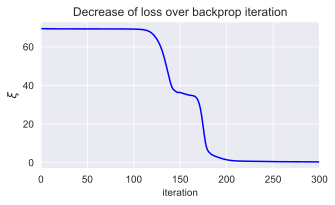

In [11]:
# Plot the loss over the iterations
fig = plt.figure(figsize=(5, 3))
plt.plot(ls_loss, 'b-')
plt.xlabel('iteration')
plt.ylabel('$L$', fontsize=12)
plt.title('Decrease of loss over backprop iteration')
plt.xlim(0, 300)
fig.subplots_adjust(bottom=0.2)
plt.show()
#

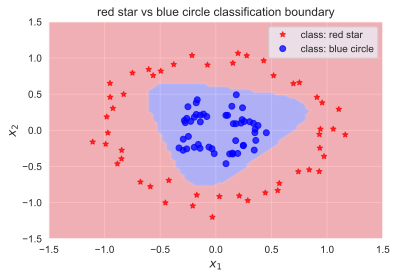

In [12]:
# Plot the resulting decision boundary
# Generate a grid over the input space to plot the color of the
#  classification at that grid point
nb_of_xs = 100
xs1 = np.linspace(-2, 2, num=nb_of_xs)
xs2 = np.linspace(-2, 2, num=nb_of_xs)
xx, yy = np.meshgrid(xs1, xs2) # create the grid
# Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        pred = nn_predict(
            np.asarray([xx[i,j], yy[i,j]]), Wh, bh, Wo, bo)
        classification_plane[i,j] = pred[0, 0]
# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('b', alpha=0.25),
        colorConverter.to_rgba('r', alpha=0.25)])
plt.figure(figsize=(6, 4))
# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, classification_plane, cmap=cmap)
# Plot both classes on the x1, x2 plane
plt.plot(x_red[:,0], x_red[:,1], 
         'r*', label='class: red star', alpha=0.75)
plt.plot(x_blue[:,0], x_blue[:,1], 
         'bo', label='class: blue circle', alpha=0.75)
plt.legend(loc=1)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red star vs blue circle classification boundary')
plt.show()

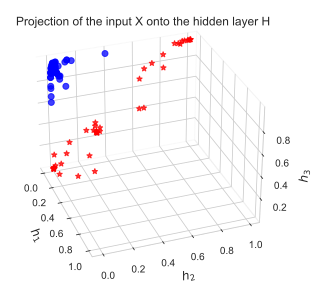

In [13]:
# Plot the projection of the input onto the hidden layer

# Define the projections of the blue and red classes
H_blue = hidden_activations(x_blue, Wh, bh)
H_red = hidden_activations(x_red, Wh, bh)
# Plot the error surface
fig = plt.figure(figsize=(6, 5))
with sns.axes_style("whitegrid"):
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.plot(
        np.ravel(H_blue[:,0]), np.ravel(H_blue[:,1]), np.ravel(H_blue[:,2]),
        'bo', label='class: blue circle', alpha=0.75)
    ax.plot(
        np.ravel(H_red[:,0]), np.ravel(H_red[:,1]), np.ravel(H_red[:,2]), 
        'r*', label='class: red star', alpha=0.75)
    ax.set_xlabel('$h_1$', fontsize=12)
    ax.set_ylabel('$h_2$', fontsize=12)
    ax.set_zlabel('$h_3$', fontsize=12)
    ax.view_init(elev=30, azim=-20)
    ax.set_title('Projection of the input X onto the hidden layer H', y=0.99)
plt.show()
#
